In [1]:
import numpy as np
import pandas as pd
import zen
import matplotlib.pyplot as plt

In [2]:
G = zen.io.gml.read('bitcoinOTC.gml',weight_fxn=lambda x: x['weight'])
#G = zen.io.gml.read('amazon_reviews_health.gml',weight_fxn=lambda x: x['weight'])

In [3]:
evc = zen.algorithms.eigenvector_centrality_(G,weighted=True)
evc = evc - np.min(evc)
evc = evc / np.max(evc)

In [6]:
def katz(G,tol=0.01,max_iter=1000,alpha=0.001,beta=1):
    iteration = 0
    centrality = np.zeros(G.num_nodes)
    while iteration < max_iter:
        iteration += 1          # increment iteration count
        centrality_old = centrality.copy()

        for node in G.nodes_():
            Ax = 0
            for neighbor in G.in_neighbors_(node):
                weight = G.weight_(G.edge_idx_(neighbor,node))
                Ax += np.multiply(centrality[neighbor],weight)

                #Ax += centrality[neighbor]      #exclude weight due to overflow in multiplication

            centrality[node] = np.multiply(alpha,Ax)+beta

        if np.sum(np.abs(np.subtract(centrality,centrality_old))) < tol:
            return centrality


In [7]:
%%time
kc = katz(G,alpha=1e-6) #1e-6
kc = kc - np.min(kc)
kc = kc / np.max(kc)

CPU times: user 620 ms, sys: 12 ms, total: 632 ms
Wall time: 623 ms


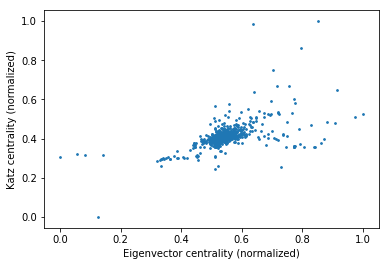

In [8]:
plt.scatter(evc,kc,s=3)
plt.xlabel('Eigenvector centrality (normalized)')
plt.ylabel('Katz centrality (normalized)')
plt.show()

In [ ]:
X = np.empty((len(evc),2))
X[:,0] = evc
X[:,1] = kc

#[0,0]s will not be compatible with cosine similarity since they have no magnitude. Add small amount.
s = pd.Series(np.array(np.where(X==0))[0])
X[s[s.duplicated()].values,:] = [1e-12,1e-12]

In [9]:
from sklearn.cluster import AgglomerativeClustering as AC

/home/markditsworth/anaconda2/lib/python2.7/site-packages/_pytest/fixtures.py:844: DeprecationWarning: The `convert` argument is deprecated in favor of `converter`.  It will be removed after 2019/01.
  params = attr.ib(convert=attr.converters.optional(tuple))


In [46]:
clusters = AC(n_clusters=2,affinity='cosine',linkage='complete').fit(X)

In [47]:
labels = clusters.labels_
print set(labels)
for x in list(set(labels)):
    print len(np.where(labels==x)[0])

set([0, 1])
658
12385


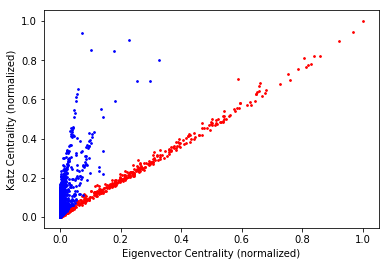

In [49]:
color = ['r','b']
for x in [0,1]:
    idx = np.where(labels==x)[0]
    plt.scatter(evc[idx],kc[idx],s=3,color=color[x])
#plt.gca().set_yscale('log')
#plt.gca().set_xscale('log')
#plt.gca().set_xlim([-1e-4,1e-4])
#plt.gca().set_ylim([-1e-4,1e-4])
plt.xlabel('Eigenvector Centrality (normalized)')
plt.ylabel('Katz Centrality (normalized)')
plt.show()

In [13]:
classes = {}
for c in [0,1]:
    idxes = np.where(labels==c)[0]
    classes[c] = [G.node_object(i) for i in idxes]

def modularity(G,classDict,classList):
    Q = zen.algorithms.modularity(G,classDict)
    # Maximum Modularity
    count=0.0
    for e in G.edges():
        n1 = G.node_idx(e[0])
        n2 = G.node_idx(e[1])
        if classList[n1] == classList[n2]:
            count += 1
    same = count / G.num_edges
    rand = same - Q
    qmax = 1 - rand
    return Q, qmax

q,qmax = modularity(G,classes,labels)
print q
print qmax
print q/qmax

0.161521136985
0.205551363098
0.78579453111


In [56]:
RED = 0
BLUE = 1
Labels = pd.Series(labels)
red_class = Labels[Labels==RED]
blue_class = Labels[Labels==BLUE]

X_sub = X[blue_class.index.values,:]

cluster2 = AC(n_clusters=2,affinity='cosine',linkage='complete').fit(X_sub)
labels2 = cluster2.labels_

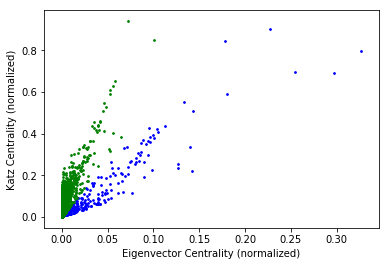

In [58]:
color = ['b','g']
for x in [0,1]:
    idx = np.where(labels2==x)[0]
    plt.scatter(X_sub[idx,0],X_sub[idx,1],s=3,color=color[x])
#plt.gca().set_yscale('log')
#plt.gca().set_xscale('log')
#plt.gca().set_xlim([-1e-4,1e-4])
#plt.gca().set_ylim([-1e-4,1e-4])
plt.xlabel('Eigenvector Centrality (normalized)')
plt.ylabel('Katz Centrality (normalized)')
plt.show()

In [60]:
green_class = blue_class.iloc[np.where(labels2==1)[0]]
blue_class_ = blue_class.iloc[np.where(labels2==0)[0]]

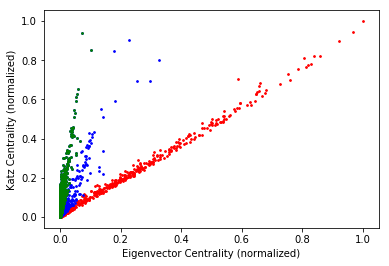

In [61]:
plt.scatter(evc[red_class.index.values],kc[red_class.index.values],s=3,color='r')
plt.scatter(evc[blue_class.index.values],kc[blue_class.index.values],s=3,color='b')
plt.scatter(evc[green_class.index.values],kc[green_class.index.values],s=3,color='g')
plt.xlabel('Eigenvector Centrality (normalized)')
plt.ylabel('Katz Centrality (normalized)')
plt.show()


In [66]:
class_dict = {0:[G.node_object(x) for x in red_class.index.values],
              1:[G.node_object(y) for y in blue_class.index.values],
              2:[G.node_object(z) for z in green_class.index.values]}
class_list = np.zeros(G.num_nodes)
class_list[blue_class.index.values] = 1
class_list[green_class.index.values] = 2
q,qmax = modularity(G,class_dict,class_list)
print q
print qmax
print q/qmax

0.267829017935
0.371200616186
0.721520941119
